## TFG MANEL

### Petita exploració de wordnet, com funciona, com es relaciona, com es l'estructura jerarquica.

1. Importació de llibreries

In [1]:
import nltk
from nltk.corpus import wordnet as wn
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import os
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

#### Arbre del wordnet
- Es tracta d'un DAG, graf dirigit aciclic. No hi ha un camí que comenci i acabi en el mateix lloc

#### L'estructura del wordnet es basa en synsets

- Synset = Conjunt de sinònims representats per un d'ells, que té un significat únic. (Unitat Base de wordnet/imagenet)
- Un node recopila tots els sinònims d'aquella paraula dintre del mateix context, dog --> gos, dog --> perrito caliente, difs contexts
-  Cada node de l'arbre és un synset que es relaciona amb altres synsets en forma d'hiponims o hyperonims

#### L'estructura del synsets
- Cada sysnset es representa com : ParaulaClau.TipusParaula.Significat.
- Paraula Base : Paraula que reciopila tota la informació, tots el sinonims. Paraula Representativa
- Tipus de Paraula : Noun, Verb, Adjective, Adverb, etc
- Significat :Numero que identifica els diferents significats d'una paraula que s'escriu igual (paraules homonimes)
ex: dog i dog dog.n.01 = gos, dog.n.02 = perrito caliente

#### Informació dintre del synset
- Nom
- Definició
- Exemples
- Sinònims

#### Hyperonims i Hyponims
- Hyperonims: Són les paraules que tenen un significat més general 
- Hyponims: Són les paraules que tenen un significat més específic
ex: Animal --> gos, gat, etc. (Animal es un hyperonim de gos)
- Per a navegar per l'arbre anirem escalant per hyperonims fins a trobar el hyperonim general per a les paraules

#### Meronyms i Holonims
- Meronyms: Parts d'un concepte , ex : Cotxe --> Roda
- Holonims: Conceptes que estan compostos per meronyms, ex : Roda --> Cotxe

#### Objetivo: 
- Encontrar aquel concepto general que relacione los difernetes top scores de cada una de las neuronas de una capa

#### LCA: Least Common Ancestor
- Conjunto mas general para el conjunto de etiquetas

## COMENÇA L'EXPLORACIÓ

Print de la informació d'un sysnset

In [2]:
dog = wn.synset('dalmatian.n.02')
# Información básica del Synset
print("Nombre del Synset:", dog.name())
print("Definición:", dog.definition())
print("Ejemplos de uso:", dog.examples())
print("Sinónimos:", dog.lemma_names())

Nombre del Synset: dalmatian.n.02
Definición: a large breed having a smooth white coat with black or brown spots; originated in Dalmatia
Ejemplos de uso: []
Sinónimos: ['dalmatian', 'coach_dog', 'carriage_dog']


Hypernims i hyponims

In [3]:
# Obtener los hypernyms de "dog.n.01"
hypernyms = dog.hypernyms()
print("Hypernyms (conceptos más generales):", [h.name() for h in hypernyms])
# Obtener los hyponyms de "dog.n.01"
hyponyms = dog.hyponyms()
print("Hyponyms (conceptos más específicos):", [h.name() for h in hyponyms])

Hypernyms (conceptos más generales): ['dog.n.01']
Hyponyms (conceptos más específicos): ['liver-spotted_dalmatian.n.01']


LCA de dos exemples: gat i gos

In [4]:
# Synsets de "dog" y "cat"
dog = wn.synset('dog.n.01')
cat = wn.synset('cat.n.01')

# Obtener el ancestro común más cercano
lca = dog.lowest_common_hypernyms(cat)
print("Ancestro común más cercano:", lca[0].name(), "-", lca[0].definition())


Ancestro común más cercano: carnivore.n.01 - a terrestrial or aquatic flesh-eating mammal


Obtenir tot el camí, amb la descripció de cada pas

In [5]:
# Obtener las rutas hacia la raíz para "dog.n.01" y "cat.n.01"
dog_paths = dog.hypernym_paths()
cat_paths = cat.hypernym_paths()

# Imprimir rutas
print("Ruta de 'dog.n.01':")
for synset in dog_paths[0]:
    print(f"  {synset.name()} - {synset.definition()}")

print("\nRuta de 'cat.n.01':")
for synset in cat_paths[0]:
    print(f"  {synset.name()} - {synset.definition()}")


Ruta de 'dog.n.01':
  entity.n.01 - that which is perceived or known or inferred to have its own distinct existence (living or nonliving)
  physical_entity.n.01 - an entity that has physical existence
  object.n.01 - a tangible and visible entity; an entity that can cast a shadow
  whole.n.02 - an assemblage of parts that is regarded as a single entity
  living_thing.n.01 - a living (or once living) entity
  organism.n.01 - a living thing that has (or can develop) the ability to act or function independently
  animal.n.01 - a living organism characterized by voluntary movement
  chordate.n.01 - any animal of the phylum Chordata having a notochord or spinal column
  vertebrate.n.01 - animals having a bony or cartilaginous skeleton with a segmented spinal column and a large brain enclosed in a skull or cranium
  mammal.n.01 - any warm-blooded vertebrate having the skin more or less covered with hair; young are born alive except for the small subclass of monotremes and nourished with milk

In [6]:
# Listar todos los Synsets de "dog"
dog_synsets = wn.synsets('dog')
for synset in dog_synsets:
    print(f"{synset.name()} - {synset.definition()}")


dog.n.01 - a member of the genus Canis (probably descended from the common wolf) that has been domesticated by man since prehistoric times; occurs in many breeds
frump.n.01 - a dull unattractive unpleasant girl or woman
dog.n.03 - informal term for a man
cad.n.01 - someone who is morally reprehensible
frank.n.02 - a smooth-textured sausage of minced beef or pork usually smoked; often served on a bread roll
pawl.n.01 - a hinged catch that fits into a notch of a ratchet to move a wheel forward or prevent it from moving backward
andiron.n.01 - metal supports for logs in a fireplace
chase.v.01 - go after with the intent to catch


Graf per a visualitzar el cami

OJO: Hi ha diferentes camins possibles per a un mateix synset, més d'un hypernim per paraula

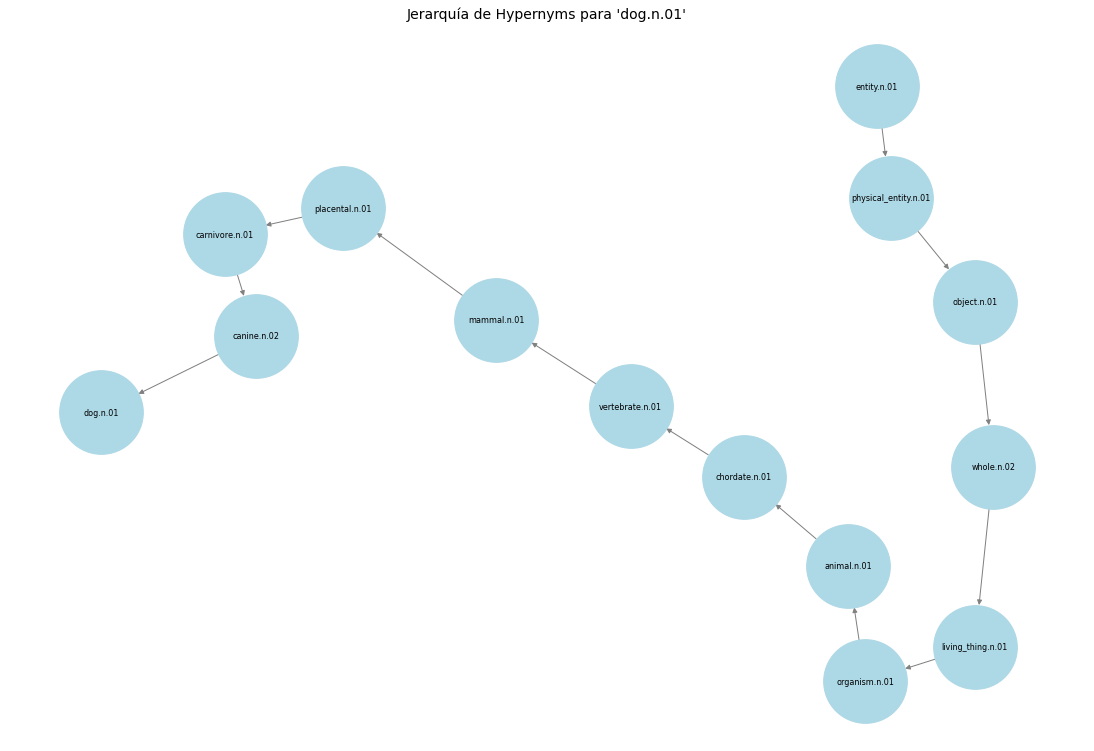

In [7]:
# Crear un grafo
G = nx.DiGraph()

# Añadir nodos y relaciones
for synset in dog.hypernym_paths()[0]:
    G.add_node(synset.name(), label=synset.name())
    if synset.hypernyms():
        G.add_edge(synset.hypernyms()[0].name(), synset.name())

# Configuración del gráfico
plt.figure(figsize=(15, 10))  # Aumentar el tamaño de la figura
pos = nx.spring_layout(G, seed=42)  # Distribución más clara
nx.draw(
    G,
    pos,
    with_labels=False,
    node_size=7000,
    node_color="lightblue",
    edge_color="gray",
    font_size=10,
)
# Añadir etiquetas con definiciones más visibles
labels = nx.get_node_attributes(G, 'label')
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, verticalalignment='center')

plt.title("Jerarquía de Hypernyms para 'dog.n.01'", fontsize=14)
plt.show()



Exemple més extens amb animals

In [8]:
# Lista de etiquetas (10 palabras)
image_labels = ['golden_retriever', 'beagle', 'labrador_retriever', 'wolf', 
                'fox', 'cat', 'lion', 'tiger', 'cheetah', 'dog']

# Convertir etiquetas a Synsets (primer Synset de cada palabra)
synsets = [wn.synsets(label, pos=wn.NOUN)[0] for label in image_labels]

# Mostrar los Synsets y sus definiciones
for synset in synsets:
    print(f"Etiqueta: {synset.name()} - {synset.definition()}")


Etiqueta: golden_retriever.n.01 - an English breed having a long silky golden coat
Etiqueta: beagle.n.01 - a small short-legged smooth-coated breed of hound
Etiqueta: labrador_retriever.n.01 - breed originally from Labrador having a short black or golden-brown coat
Etiqueta: wolf.n.01 - any of various predatory carnivorous canine mammals of North America and Eurasia that usually hunt in packs
Etiqueta: fox.n.01 - alert carnivorous mammal with pointed muzzle and ears and a bushy tail; most are predators that do not hunt in packs
Etiqueta: cat.n.01 - feline mammal usually having thick soft fur and no ability to roar: domestic cats; wildcats
Etiqueta: lion.n.01 - large gregarious predatory feline of Africa and India having a tawny coat with a shaggy mane in the male
Etiqueta: tiger.n.01 - a fierce or audacious person
Etiqueta: cheetah.n.01 - long-legged spotted cat of Africa and southwestern Asia having nonretractile claws; the swiftest mammal; can be trained to run down game
Etiqueta: do

In [9]:
# Encontrar el ancestro común más cercano
common_ancestor = synsets[0]  # Empezamos con el primer Synset
for synset in synsets[1:]:    # Iteramos sobre los demás
    common_ancestor = common_ancestor.lowest_common_hypernyms(synset)[0]

# Mostrar el resultado
print("Ancestro común más cercano:")
print(f"  {common_ancestor.name()} - {common_ancestor.definition()}")


Ancestro común más cercano:
  organism.n.01 - a living thing that has (or can develop) the ability to act or function independently


In [10]:
# Ruta hacia la raíz
hypernym_path = common_ancestor.hypernym_paths()[0]

print("Ruta hacia la raíz:")
for hypernym in hypernym_path:
    print(f"  {hypernym.name()} - {hypernym.definition()}")


Ruta hacia la raíz:
  entity.n.01 - that which is perceived or known or inferred to have its own distinct existence (living or nonliving)
  physical_entity.n.01 - an entity that has physical existence
  object.n.01 - a tangible and visible entity; an entity that can cast a shadow
  whole.n.02 - an assemblage of parts that is regarded as a single entity
  living_thing.n.01 - a living (or once living) entity
  organism.n.01 - a living thing that has (or can develop) the ability to act or function independently


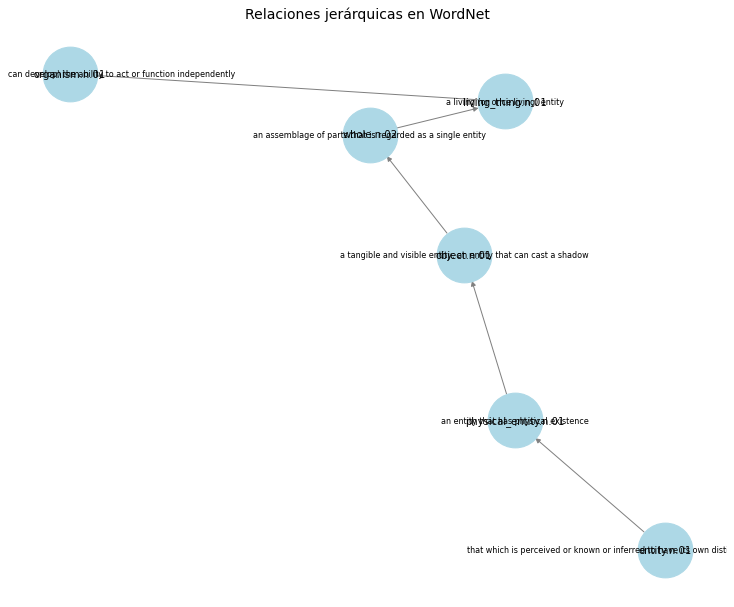

In [11]:
# Crear un grafo
G = nx.DiGraph()

# Añadir nodos y relaciones
for synset in hypernym_path:
    G.add_node(synset.name(), label=synset.definition())
    if synset.hypernyms():
        G.add_edge(synset.hypernyms()[0].name(), synset.name())

# Configurar el gráfico
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", edge_color="gray", font_size=10)
labels = nx.get_node_attributes(G, 'label')
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, verticalalignment='center')

plt.title("Relaciones jerárquicas en WordNet", fontsize=14)
plt.show()


## Similaritats entre les definicions

In [12]:
# Definiciones de los Synsets
definitions = [synset.definition() for synset in synsets]

# Calcular vectores TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(definitions)

# Calcular similitud coseno entre las definiciones
similarity_matrix = cosine_similarity(tfidf_matrix)
print("Matriz de similitud:")
print(similarity_matrix)


Matriz de similitud:
[[1.         0.09032877 0.31070855 0.         0.         0.04116789
  0.1054667  0.         0.10414647 0.        ]
 [0.09032877 1.         0.17519629 0.07654285 0.         0.
  0.03958876 0.         0.10041574 0.02964475]
 [0.31070855 0.17519629 1.         0.         0.         0.03461853
  0.08868811 0.12962067 0.02872    0.05298597]
 [0.         0.07654285 0.         1.         0.25748113 0.08343271
  0.17162625 0.         0.06809628 0.09825884]
 [0.         0.         0.         0.25748113 1.         0.08697805
  0.1285766  0.         0.07215818 0.05112363]
 [0.04116789 0.         0.03461853 0.08343271 0.08697805 1.
  0.11460694 0.         0.13225882 0.        ]
 [0.1054667  0.03958876 0.08868811 0.17162625 0.1285766  0.11460694
  1.         0.         0.15539098 0.11366035]
 [0.         0.         0.12962067 0.         0.         0.
  0.         1.         0.         0.        ]
 [0.10414647 0.10041574 0.02872    0.06809628 0.07215818 0.13225882
  0.15539098 0.

In [13]:
# Generar resumen simple
def generate_summary(synsets):
    definitions = [synset.definition() for synset in synsets]
    summary = " Esta neurona responde a conceptos como: " + ", ".join(definitions)
    return summary

# Ejemplo
summary = generate_summary(synsets)
print(summary)


 Esta neurona responde a conceptos como: an English breed having a long silky golden coat, a small short-legged smooth-coated breed of hound, breed originally from Labrador having a short black or golden-brown coat, any of various predatory carnivorous canine mammals of North America and Eurasia that usually hunt in packs, alert carnivorous mammal with pointed muzzle and ears and a bushy tail; most are predators that do not hunt in packs, feline mammal usually having thick soft fur and no ability to roar: domestic cats; wildcats, large gregarious predatory feline of Africa and India having a tawny coat with a shaggy mane in the male, a fierce or audacious person, long-legged spotted cat of Africa and southwestern Asia having nonretractile claws; the swiftest mammal; can be trained to run down game, a member of the genus Canis (probably descended from the common wolf) that has been domesticated by man since prehistoric times; occurs in many breeds


## TASCA 1

- Ens ve la informació per carpetes:
    - 1 Llistes TFG
        - 2 Capes
            - 3 Neurones de cada capa
                - 4 Top 100 imatges de cada una de les neurones

Llegir la informació de les llistes que ens han donat i crar un mapping per a poder tindre en forma de classe de imagenet per a poder fer una posterior cerca

Definiré diferntes funcions:
- 1 Llegir els documents
- 2 Crear el mapping
- 3 Crear nou document amb els synsets de l'imagenet

## Pas 1: Càrrega de les dades de les capes

En aquest pas, carregarem els arxius `.npy` que contenen les dades de les diferents capes de la xarxa neuronal. 
Cada capa conté una matriu on cada fila representa una neurona i les seves imatges associades.

### **Objectiu**
- Llegir els arxius `.npy` de les diferents capes (`relu`, `layer1`, `layer2`, `layer3`).
- Organitzar les dades en un diccionari per accedir-hi fàcilment.
- Verificar la mida de cada capa després de carregar-les.


1.Leer los archivos guardado en formado array

In [14]:
def cargar_datos_capas(base_path, capas):
    """
    Carga los archivos .npy de diferentes capas y los organiza en un diccionario.
    
    Parámetros:
    - base_path: ruta donde están los archivos .npy.
    - capas: lista con los nombres de las capas a cargar.
    
    Retorna:
    - diccionario donde las claves son los nombres de las capas y los valores son los datos cargados.
    """
    datos = {}
    for capa in capas:
        file_path = os.path.join(base_path, f"{capa}.npy")
        if os.path.exists(file_path):
            datos[capa] = np.load(file_path, allow_pickle=True)
            print(f"📥 Cargado {capa} - Shape: {datos[capa].shape}")
        else:
            print(f"⚠️ No se encontró {file_path}")
    return datos

# 📌 Parámetros
base_path = "../Data/"  # Cambia esto si los archivos están en otra carpeta
capas = ["relu", "layer1", "layer2", "layer3"]  # Lista de nombres de capas

# 📥 Cargar todas las capas
datos_capas = cargar_datos_capas(base_path, capas)

📥 Cargado relu - Shape: (64, 100)
📥 Cargado layer1 - Shape: (256, 100)
📥 Cargado layer2 - Shape: (512, 100)
📥 Cargado layer3 - Shape: (1024, 100)


## Pas 2

In [15]:
def wnid_a_synset(wnid):
    """
    Converteix un WNID d'ImageNet a un synset de WordNet utilitzant NLTK.

    Paràmetres:
    - wnid: str, identificador WNID d'ImageNet (exemple: 'n02119789').

    Retorna:
    - Synset de WordNet si existeix, altrament None.
    """
    try:
        synset = wn.synset_from_pos_and_offset('n', int(wnid[1:]))  # Convertim el codi WNID en un synset
        return synset
    except:
        return None

# 📌 Provar amb un WNID d'exemple
wnid_exemple = "n02119789"  # Kit fox
synset = wnid_a_synset(wnid_exemple)

if synset:
    print(f"WNID: {wnid_exemple}")
    print(f"Synset: {synset}")
    print(f"Definició: {synset.definition()}")
    print(f"Sinònims: {synset.lemma_names()}")
else:
    print(f"No s'ha trobat un synset per {wnid_exemple}")


WNID: n02119789
Synset: Synset('kit_fox.n.01')
Definició: small grey fox of southwestern United States; may be a subspecies of Vulpes velox
Sinònims: ['kit_fox', 'Vulpes_macrotis']


In [16]:
def carregar_mapeig_wnid(ruta_fitxer):
    """
    Carrega el fitxer `Image_net_Classes.txt` i construeix un diccionari {WNID: nom_classe}.

    Paràmetres:
    - ruta_fitxer: str, ruta de l'arxiu.

    Retorna:
    - Diccionari {WNID: nom_classe}.
    """
    mapeig = {}
    with open(ruta_fitxer, "r") as f:
        for linia in f:
            parts = linia.strip().split(": ")  # Format: "nxxxxx: nom_classe"
            if len(parts) == 2:
                wnid, nom_classe = parts
                mapeig[wnid] = nom_classe
    return mapeig

# 📌 Càrrega del mapeig
ruta_mapeig = "../Data/Image_net_Classes.txt"  # Ajusta la ruta si cal
mapeig_wnids_manual = carregar_mapeig_wnid(ruta_mapeig)

# 📌 Veiem alguns exemples
list(mapeig_wnids_manual.items())[:5]


[('n02119789', 'kit fox, Vulpes macrotis'),
 ('n02100735', 'English setter'),
 ('n02096294', 'Australian terrier'),
 ('n02066245',
  'grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus'),
 ('n02509815',
  'lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens')]

In [34]:
def obtenir_synset_desc(wnid, mapeig_manual):
    """
    Intenta obtenir la informació d'un WNID utilitzant WordNet i, si no funciona, usa el mapeig manual.

    Paràmetres:
    - wnid: str, identificador WNID d'ImageNet.
    - mapeig_manual: dict, diccionari {WNID: nom_classe} carregat de `Image_net_Classes.txt`.

    Retorna:
    - Tuple (synset, definició, sinònims).
    """
    synset = wnid_a_synset(wnid)
    if synset:
        return synset, synset.definition(), synset.lemma_names()
    elif wnid in mapeig_manual:
        return None, f"Nom a ImageNet: {mapeig_manual[wnid]}", []
    else:
        return None, "Sense informació", []

# 📌 Provar amb un exemple
wnid_exemple = "n02119789"  # Kit fox
resultat = obtenir_synset(wnid_exemple, mapeig_wnids_manual)

print(f"WNID: {wnid_exemple}")
print(f"Synset: {resultat[0]}")
print(f"Descripció: {resultat[1]}")
print(f"Sinònims: {resultat[2]}")


WNID: n02119789
Synset: Synset('kit_fox.n.01')
Descripció: small grey fox of southwestern United States; may be a subspecies of Vulpes velox
Sinònims: ['kit_fox', 'Vulpes_macrotis']


In [54]:
from collections import Counter

def processar_capa_wnids(capa, dades_capas, mapeig_manual, top_n=5):
    """
    Processa totes les neurones d'una capa i obté les seves descripcions semàntiques, 
    prioritzant els WNIDs més repetits.

    Paràmetres:
    - capa: str, nom de la capa ('relu', 'layer1', etc.).
    - dades_capas: dict, diccionari amb totes les capes carregades.
    - mapeig_manual: dict, mapeig {WNID: nom_classe}.
    - top_n: int, nombre de WNIDs més activadors a mostrar per cada neurona.

    Retorna:
    - Diccionari {neurona: [(synset, definició, sinònims, freqüència)]}, 
      on cada neurona té només els WNIDs més activadors.
    """
    if capa not in dades_capas:
        print(f"La capa '{capa}' no existeix.")
        return {}

    capa_wnids = {}
    total_neurones = len(dades_capas[capa])
    print(f"\n====== Processant capa: {capa} ({total_neurones} neurones) ======")

    for neuron_idx, row in enumerate(dades_capas[capa]):
        wnids_counter = Counter(path.split('/')[0] for path in row)  # Contar repeticions de cada WNID
        total_wnids = sum(wnids_counter.values())  
        wnids_unics = len(wnids_counter)  

        # Obtenir els WNIDs més activadors
        wnids_most_common = wnids_counter.most_common(top_n)

        # Processar només els WNIDs més freqüents
        descripcions = [(obtenir_synset_desc(wnid, mapeig_manual), freq) for wnid, freq in wnids_most_common]

        # Comptar quants WNIDs es van convertir amb èxit
        wnids_valids = sum(1 for (synset, _, _), _ in descripcions if synset is not None)
        ratio_conversion = (wnids_valids / len(wnids_most_common)) * 100 if wnids_most_common else 0
        mitjana_sinonims = sum(len(sinonims) for (synset, _, sinonims), _ in descripcions if sinonims) / wnids_valids if wnids_valids > 0 else 0

        # Guardar resultats prioritzant els WNIDs més freqüents
        capa_wnids[f"neuron_{neuron_idx}"] = descripcions

        # Imprimir mètriques per neurona
        print(f"\nNeurona {neuron_idx}:")
        print(f"  - Total imatges processades: {total_wnids}")
        print(f"  - Total WNIDs diferents: {wnids_unics}")
        print(f"  - WNIDs convertits correctament: {wnids_valids}")
        print(f"  - Ràtio de conversió: {ratio_conversion:.2f}%")
        print(f"  - Mitjana de sinònims per synset: {mitjana_sinonims:.2f}")
        print(f"  - Principals WNIDs que activen la neurona:")
        for (synset, definicio, sinonims), freq in descripcions:
            print(f"    - {synset}: {definicio} (Freqüència: {freq})")

    return capa_wnids



Funció Main per a poder processar totes les capes alhora i crear un json amb els synsets que hem mapejat

In [55]:
def processar_totes_les_capes(dades_capas, mapeig_manual):
    """
    Processa totes les capes disponibles i obté les descripcions semàntiques de les seves neurones amb estadístiques.

    Paràmetres:
    - dades_capas: dict, diccionari amb totes les capes carregades.
    - mapeig_manual: dict, mapeig {WNID: nom_classe}.

    Retorna:
    - Diccionari {capa: {neurona: [(synset, definició, sinònims)]}}, estructurat per capa i neurona.
    """
    resultats = {}
    print("\n===== INICI DEL PROCESSAMENT DE TOTES LES CAPES =====\n")

    for capa in dades_capas.keys():
        resultats[capa] = processar_capa_wnids(capa, dades_capas, mapeig_manual)

    print("\n===== FI DEL PROCESSAMENT DE TOTES LES CAPES =====\n")
    return resultats


In [56]:
resultats_totals = processar_totes_les_capes(datos_capas, mapeig_wnids_manual)



===== INICI DEL PROCESSAMENT DE TOTES LES CAPES =====


====== Processant capa: relu (64 neurones) ======

Neurona 0:
  - Total imatges processades: 100
  - Total WNIDs diferents: 74
  - WNIDs convertits correctament: 5
  - Ràtio de conversió: 100.00%
  - Mitjana de sinònims per synset: 1.00
  - Principals WNIDs que activen la neurona:
    - Synset('zebra.n.01'): any of several fleet black-and-white striped African equines (Freqüència: 18)
    - Synset('buckle.n.01'): fastener that fastens together two ends of a belt or strap; often has loose prong (Freqüència: 3)
    - Synset('typewriter_keyboard.n.01'): a keyboard for manually entering characters to be printed (Freqüència: 2)
    - Synset('cardoon.n.02'): only parts eaten are roots and especially stalks (blanched and used as celery); related to artichokes (Freqüència: 2)
    - Synset('suspension_bridge.n.01'): a bridge that has a roadway supported by cables that are anchored at both ends (Freqüència: 2)

Neurona 1:
  - Total imatges

In [66]:
# Verificar la cantidad de imágenes por neurona en relu.npy
capa = "relu"

for i, row in enumerate(datos_capas[capa][:5]):  # Solo inspeccionamos las 5 primeras neuronas
    print(f"\nNeurona {i} - Imatges assignades: {len(row)}")
    wnids = [path.split('/')[0] for path in row]
    wnids_unics = set(wnids)
    print(f"  - WNIDs totals: {len(wnids)}")  # Debería ser 100
    print(f"  - WNIDs únics: {len(wnids_unics)}")  # Si es menor, hay repetidos
    print(f"  - Exemples de WNIDs: {list(wnids_unics)[:5]}")



Neurona 0 - Imatges assignades: 100
  - WNIDs totals: 100
  - WNIDs únics: 74
  - Exemples de WNIDs: ['n02859443', 'n02895154', 'n04392985', 'n03770439', 'n03873416']

Neurona 1 - Imatges assignades: 100
  - WNIDs totals: 100
  - WNIDs únics: 75
  - Exemples de WNIDs: ['n04392985', 'n03110669', 'n03958227', 'n01755581', 'n04033901']

Neurona 2 - Imatges assignades: 100
  - WNIDs totals: 100
  - WNIDs únics: 74
  - Exemples de WNIDs: ['n02133161', 'n02111277', 'n03110669', 'n02701002', 'n02480855']

Neurona 3 - Imatges assignades: 100
  - WNIDs totals: 100
  - WNIDs únics: 83
  - Exemples de WNIDs: ['n03047690', 'n03045698', 'n04204238', 'n04118538', 'n02093256']

Neurona 4 - Imatges assignades: 100
  - WNIDs totals: 100
  - WNIDs únics: 83
  - Exemples de WNIDs: ['n03017168', 'n02966193', 'n04259630', 'n02093256', 'n03769881']


Impresio de tots els resultats que hem obtingut.

Es un json amb {layer : {neurona x : [(synset,descr,nom)]}}

## Funcions d'analisis

In [69]:
def veure_classes_més_repetides(capa, dades_capas, mapeig_manual, top_n=5):
    """
    Mostra les classes d'ImageNet més repetides per cada neurona en una capa donada.

    Paràmetres:
    - capa: str, nom de la capa ('relu', 'layer1', etc.).
    - dades_capas: dict, diccionari amb totes les capes carregades.
    - mapeig_manual: dict, diccionari {WNID: nom_classe} carregat de `Image_net_Classes.txt`.
    - top_n: int, nombre de classes més repetides a mostrar per cada neurona.
    
    Retorna:
    - No retorna res, només imprimeix la informació per pantalla.
    """
    if capa not in dades_capas:
        print(f"La capa '{capa}' no existeix.")
        return
    
    print(f"\n====== Distribució de classes en la capa: {capa} ======")
    
    for neuron_idx, row in enumerate(dades_capas[capa]):
        wnids_counter = Counter(path.split('/')[0] for path in row)  # Comptem els WNIDs
        
        print(f"\n🔹 Neurona {neuron_idx} (Total WNIDs únics: {len(wnids_counter)})")

        # Mostrar només els WNIDs més repetits
        for wnid, freq in wnids_counter.most_common(top_n):
            nom_classe = mapeig_manual.get(wnid, "Desconegut")  # Convertim el WNID a nom de classe
            print(f"  - {wnid} ({nom_classe}): {freq} vegades")


In [71]:
veure_classes_més_repetides("layer3", datos_capas, mapeig_wnids_manual, top_n=5)



====== Distribució de classes en la capa: layer3 ======

🔹 Neurona 0 (Total WNIDs únics: 94)
  - n02877765 (bottlecap): 2 vegades
  - n07697537 (hotdog, hot dog, red hot): 2 vegades
  - n07717410 (acorn squash): 2 vegades
  - n02165456 (ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle): 2 vegades
  - n03871628 (packet): 2 vegades

🔹 Neurona 1 (Total WNIDs únics: 49)
  - n02037110 (oystercatcher, oyster catcher): 10 vegades
  - n01824575 (coucal): 9 vegades
  - n02364673 (guinea pig, Cavia cobaya): 8 vegades
  - n02328150 (Angora, Angora rabbit): 8 vegades
  - n02006656 (spoonbill): 4 vegades

🔹 Neurona 2 (Total WNIDs únics: 70)
  - n02494079 (squirrel monkey, Saimiri sciureus): 10 vegades
  - n03110669 (cornet, horn, trumpet, trump): 5 vegades
  - n02108000 (EntleBucher): 4 vegades
  - n02088632 (bluetick): 3 vegades
  - n02107908 (Appenzeller): 3 vegades

🔹 Neurona 3 (Total WNIDs únics: 67)
  - n01860187 (black swan, Cygnus atratus): 9 vegades
  - n02417914 (ibex, Capra ib

## Busqueda del concepte predominant

1. Escollir aquelles classes mes preodiminants i pujar un hypernim

In [77]:
from collections import Counter
from nltk.corpus import wordnet as wn

def obtenir_concepte_general(wnid):
    """
    Busca el hiperònim més representatiu per a un WNID en WordNet,
    explorant múltiples camins si cal.
    """
    try:
        synset = wn.synset_from_pos_and_offset('n', int(wnid[1:]))
        hypernyms = list(synset.closure(lambda s: s.hypernyms()))  # Tots els camins cap a la arrel

        if hypernyms:
            counter = Counter([h.lemmas()[0].name() for h in hypernyms])
            concepte = counter.most_common(1)[0][0]  # Agafem el més repetit
            return synset, concepte

        return synset, synset.lemmas()[0].name()  # Si no té hiperònims, retornem el mateix

    except:
        return None, "Sense informació"


def agrupar_conceptes_neurona(capa, dades_capas, mapeig_manual, top_n=5):
    """
    Agrupa les classes més repetides d'una neurona en un concepte general.

    Paràmetres:
    - capa: str, nom de la capa ('relu', 'layer1', etc.).
    - dades_capas: dict, diccionari amb totes les capes carregades.
    - mapeig_manual: dict, diccionari {WNID: nom_classe}.
    - top_n: int, nombre de classes més repetides a considerar.

    Retorna:
    - Diccionari {neurona: {concepte_predominant: freq}}
    """
    if capa not in dades_capas:
        print(f"La capa '{capa}' no existeix.")
        return {}

    agrupacions = {}

    print(f"\n====== Identificació de conceptes predominants per la capa: {capa} ======")

    for neuron_idx, row in enumerate(dades_capas[capa]):
        wnids_counter = Counter(path.split('/')[0] for path in row)  # Comptem els WNIDs
        wnids_most_common = wnids_counter.most_common(top_n)  # Agafem només els més freqüents
        
        conceptes_counter = Counter()
        for wnid, freq in wnids_most_common:
            synset, concepte = obtenir_concepte_general(wnid)
            conceptes_counter[concepte] += freq  # Sumem la freqüència

        # Agafem el concepte predominant (el més repetit)
        if conceptes_counter:
            concepte_predominant, freq_max = conceptes_counter.most_common(1)[0]
        else:
            concepte_predominant, freq_max = "Sense informació", 0

        agrupacions[f"neuron_{neuron_idx}"] = {
            "concepte_predominant": concepte_predominant,
            "freq": freq_max,
            "distribució": dict(conceptes_counter)
        }

        # Imprimim els resultats
        print(f"\n🔹 Neurona {neuron_idx}")
        print(f"  - Concepte predominant: {concepte_predominant} ({freq_max} vegades)")
        print(f"  - Distribució de conceptes:")
        for concepte, freq in conceptes_counter.items():
            print(f"    - {concepte}: {freq} vegades")

    return agrupacions


In [79]:
agrupacions_capa_relu = agrupar_conceptes_neurona("layer3", datos_capas, mapeig_wnids_manual, top_n=10)



====== Identificació de conceptes predominants per la capa: layer3 ======

🔹 Neurona 0
  - Concepte predominant: cap (2 vegades)
  - Distribució de conceptes:
    - cap: 2 vegades
    - sandwich: 2 vegades
    - winter_squash: 2 vegades
    - beetle: 2 vegades
    - package: 2 vegades
    - edible_fruit: 2 vegades
    - artifact: 1 vegades
    - terrier: 1 vegades
    - object: 1 vegades
    - crab: 1 vegades

🔹 Neurona 1
  - Concepte predominant: shorebird (10 vegades)
  - Distribució de conceptes:
    - shorebird: 10 vegades
    - cuckoo: 9 vegades
    - cavy: 8 vegades
    - rabbit: 8 vegades
    - wading_bird: 4 vegades
    - car: 4 vegades
    - van: 4 vegades
    - sled_dog: 3 vegades
    - coot: 3 vegades
    - hawk: 2 vegades

🔹 Neurona 2
  - Concepte predominant: New_World_monkey (10 vegades)
  - Distribució de conceptes:
    - New_World_monkey: 10 vegades
    - brass: 5 vegades
    - Sennenhunde: 7 vegades
    - hound: 3 vegades
    - viverrine: 2 vegades
    - double-reed_i

c:\Users\manel\anaconda3\lib\site-packages\nltk\corpus\reader\wordnet.py:599: UserWarning: Discarded redundant search for Synset('object.n.01') at depth 8
  for synset in acyclic_breadth_first(self, rel, depth):
c:\Users\manel\anaconda3\lib\site-packages\nltk\corpus\reader\wordnet.py:599: UserWarning: Discarded redundant search for Synset('animal.n.01') at depth 11
  for synset in acyclic_breadth_first(self, rel, depth):
c:\Users\manel\anaconda3\lib\site-packages\nltk\corpus\reader\wordnet.py:599: UserWarning: Discarded redundant search for Synset('vehicle.n.01') at depth 6
  for synset in acyclic_breadth_first(self, rel, depth):
c:\Users\manel\anaconda3\lib\site-packages\nltk\corpus\reader\wordnet.py:599: UserWarning: Discarded redundant search for Synset('substance.n.07') at depth 7
  for synset in acyclic_breadth_first(self, rel, depth):
c:\Users\manel\anaconda3\lib\site-packages\nltk\corpus\reader\wordnet.py:599: UserWarning: Discarded redundant search for Synset('matter.n.03') at 


  - Concepte predominant: meter (7 vegades)
  - Distribució de conceptes:
    - meter: 7 vegades
    - clock: 3 vegades
    - car: 3 vegades
    - armor_plate: 2 vegades
    - artifact: 2 vegades
    - timepiece: 2 vegades
    - monotreme: 2 vegades
    - great_ape: 2 vegades
    - van: 2 vegades
    - cart: 2 vegades

🔹 Neurona 116
  - Concepte predominant: springer_spaniel (17 vegades)
  - Distribució de conceptes:
    - toy_spaniel: 15 vegades
    - English_toy_spaniel: 10 vegades
    - Sennenhunde: 13 vegades
    - shepherd_dog: 13 vegades
    - springer_spaniel: 17 vegades
    - corgi: 5 vegades
    - spaniel: 3 vegades

🔹 Neurona 117
  - Concepte predominant: pudding (7 vegades)
  - Distribució de conceptes:
    - pudding: 7 vegades
    - calculator: 5 vegades
    - jewelry: 5 vegades
    - telephone: 4 vegades
    - sauce: 3 vegades
    - artifact: 3 vegades
    - watch: 2 vegades
    - mechanical_device: 2 vegades
    - edible_fruit: 2 vegades
    - timer: 2 vegades

🔹 Neurona

c:\Users\manel\anaconda3\lib\site-packages\nltk\corpus\reader\wordnet.py:599: UserWarning: Discarded redundant search for Synset('animal.n.01') at depth 6
  for synset in acyclic_breadth_first(self, rel, depth):
c:\Users\manel\anaconda3\lib\site-packages\nltk\corpus\reader\wordnet.py:599: UserWarning: Discarded redundant search for Synset('artifact.n.01') at depth 4
  for synset in acyclic_breadth_first(self, rel, depth):



    - hound: 15 vegades
    - wolf: 10 vegades
    - canine: 5 vegades
    - shepherd_dog: 4 vegades
    - retriever: 4 vegades
    - wild_dog: 4 vegades
    - watchdog: 3 vegades
    - Belgian_sheepdog: 3 vegades
    - hunting_dog: 3 vegades

🔹 Neurona 220
  - Concepte predominant: gymnastic_apparatus (3 vegades)
  - Distribució de conceptes:
    - gymnastic_apparatus: 3 vegades
    - office_furniture: 2 vegades
    - kitchen_appliance: 2 vegades
    - oven: 2 vegades
    - equipment: 2 vegades
    - contestant: 2 vegades
    - object: 2 vegades
    - lamp: 2 vegades
    - measuring_instrument: 2 vegades
    - cabinet: 2 vegades

🔹 Neurona 221
  - Concepte predominant: domestic_cat (7 vegades)
  - Distribució de conceptes:
    - food: 4 vegades
    - domestic_cat: 7 vegades
    - butterfly: 3 vegades
    - dip: 3 vegades
    - musical_instrument: 3 vegades
    - pan: 4 vegades
    - dish: 2 vegades
    - portable_computer: 2 vegades

🔹 Neurona 222
  - Concepte predominant: jewelry (2

2. LCA

MOLT GENERAL

In [88]:
def trobar_LCA(synsets):
    """
    Troba l'ancestre comú més baix (LCA) de manera optimitzada,
    evitant que sigui massa general (ex. 'whole', 'entity').
    
    Paràmetres:
    - synsets: Llista de synsets de WordNet.

    Retorna:
    - Synset més específic que comparteixen totes les classes.
    """
    if not synsets:
        return None

    # Obtenim la jerarquia completa de cada synset fins a la arrel
    camins = [set(s.closure(lambda s: s.hypernyms())) for s in synsets]

    # Trobar la intersecció entre tots els camins
    interseccio = set.intersection(*camins)

    if interseccio:
        # Ordenem per profunditat (més camins a la arrel → més específic)
        lca_candidates = sorted(interseccio, key=lambda s: len(list(s.closure(lambda s: s.hypernyms()))), reverse=True)

        # Evitem categories massa generals com 'whole', 'entity'
        for lca in lca_candidates:
            if lca.name() not in {"whole.n.01", "entity.n.01", "object.n.01"}:
                return lca

        # Si només trobem conceptes massa generals, retornem el més profund disponible
        return lca_candidates[0] 

    return None  # Si no hi ha cap ancestre comú


In [89]:
def agrupar_conceptes_neurona_LCA(capa, dades_capas, mapeig_manual, top_n=5):
    """
    Agrupa les classes més repetides d'una neurona trobant el LCA (Lowest Common Ancestor).

    Paràmetres:
    - capa: str, nom de la capa ('relu', 'layer1', etc.).
    - dades_capas: dict, diccionari amb totes les capes carregades.
    - mapeig_manual: dict, diccionari {WNID: nom_classe}.
    - top_n: int, nombre de classes més repetides a considerar.

    Retorna:
    - Diccionari {neurona: {concepte_predominant: freq}}
    """
    if capa not in dades_capas:
        print(f"La capa '{capa}' no existeix.")
        return {}

    agrupacions = {}

    print(f"\n====== Identificació de conceptes predominants per la capa: {capa} ======")

    for neuron_idx, row in enumerate(dades_capas[capa]):
        wnids_counter = Counter(path.split('/')[0] for path in row)  # Comptem els WNIDs
        wnids_most_common = wnids_counter.most_common(top_n)

        synsets = []
        for wnid, _ in wnids_most_common:
            try:
                synset = wn.synset_from_pos_and_offset('n', int(wnid[1:]))  # Convertir WNID a Synset
                synsets.append(synset)
            except:
                continue  # Si no hi ha synset, el saltem

        # Trobar el LCA entre tots els synsets
        lca = trobar_LCA(synsets)

        # Si trobem un LCA, el fem servir com a concepte principal
        if lca:
            concepte_predominant = lca.lemmas()[0].name()
        else:
            concepte_predominant = "Sense informació"

        agrupacions[f"neuron_{neuron_idx}"] = {
            "concepte_predominant": concepte_predominant,
            "distribució": [s.name() for s in synsets]
        }

        # Imprimim els resultats
        print(f"\n🔹 Neurona {neuron_idx}")
        print(f"  - Concepte predominant: {concepte_predominant}")
        print(f"  - Distribució de synsets:")
        for s in synsets:
            print(f"    - {s.name()}")

    return agrupacions


In [90]:
agrupar_conceptes_neurona_LCA("layer3", datos_capas, mapeig_wnids_manual, top_n=5)


====== Identificació de conceptes predominants per la capa: layer3 ======

🔹 Neurona 0
  - Concepte predominant: physical_entity
  - Distribució de synsets:
    - bottlecap.n.01
    - hotdog.n.02
    - acorn_squash.n.02
    - ladybug.n.01
    - packet.n.03

🔹 Neurona 1
  - Concepte predominant: vertebrate
  - Distribució de synsets:
    - oystercatcher.n.01
    - coucal.n.01
    - guinea_pig.n.02
    - angora.n.03
    - spoonbill.n.01

🔹 Neurona 2
  - Concepte predominant: whole
  - Distribució de synsets:
    - squirrel_monkey.n.01
    - cornet.n.01
    - entlebucher.n.01
    - bluetick.n.01
    - appenzeller.n.01

🔹 Neurona 3
  - Concepte predominant: vertebrate
  - Distribució de synsets:
    - black_swan.n.01
    - ibex.n.01
    - hornbill.n.01
    - bee_eater.n.01
    - black_stork.n.01

🔹 Neurona 4
  - Concepte predominant: physical_entity
  - Distribució de synsets:
    - monitor.n.05
    - cardoon.n.02
    - sandbar.n.01
    - mailbox.n.01
    - ladybug.n.01

🔹 Neurona 5
  - C

{'neuron_0': {'concepte_predominant': 'physical_entity',
  'distribució': ['bottlecap.n.01',
   'hotdog.n.02',
   'acorn_squash.n.02',
   'ladybug.n.01',
   'packet.n.03']},
 'neuron_1': {'concepte_predominant': 'vertebrate',
  'distribució': ['oystercatcher.n.01',
   'coucal.n.01',
   'guinea_pig.n.02',
   'angora.n.03',
   'spoonbill.n.01']},
 'neuron_2': {'concepte_predominant': 'whole',
  'distribució': ['squirrel_monkey.n.01',
   'cornet.n.01',
   'entlebucher.n.01',
   'bluetick.n.01',
   'appenzeller.n.01']},
 'neuron_3': {'concepte_predominant': 'vertebrate',
  'distribució': ['black_swan.n.01',
   'ibex.n.01',
   'hornbill.n.01',
   'bee_eater.n.01',
   'black_stork.n.01']},
 'neuron_4': {'concepte_predominant': 'physical_entity',
  'distribució': ['monitor.n.05',
   'cardoon.n.02',
   'sandbar.n.01',
   'mailbox.n.01',
   'ladybug.n.01']},
 'neuron_5': {'concepte_predominant': 'whole',
  'distribució': ['laptop.n.01',
   'notebook.n.02',
   'padlock.n.01',
   'leonberg.n.01',

In [91]:
import numpy as np
from collections import Counter
from nltk.corpus import wordnet as wn

def trobar_LCA_ajustat(synsets, min_frequencia=0.6):
    """
    Troba el hiperònim més baix en la jerarquia que apareix en un mínim del 60% dels synsets.
    """
    if not synsets:
        return None

    # Obtenir hiperònims de cada synset
    camins = [set(s.closure(lambda s: s.hypernyms())) for s in synsets]

    # Trobar la intersecció més profunda entre els camins
    interseccio = set.intersection(*camins)

    if not interseccio:
        return None  # No hi ha cap LCA clar

    # Comptar quantes vegades apareix cada hiperònim
    counter = Counter([h for cami in camins for h in cami])
    total_synsets = len(synsets)

    # Seleccionar l'hiperònim més baix que apareix en almenys el 60% dels synsets
    candidats = [h for h, freq in counter.items() if freq / total_synsets >= min_frequencia]

    if candidats:
        return max(candidats, key=lambda s: len(list(s.closure(lambda s: s.hypernyms()))))

    return None  # No trobem cap hiperònim dominant

def calcular_entropia(distribucio):
    """
    Calcula l'entropia d'una distribució de conceptes en una neurona.
    """
    total = sum(distribucio.values())
    probs = [freq / total for freq in distribucio.values()]
    return -sum(p * np.log2(p) for p in probs if p > 0)

def processar_neurones_amb_LCA(capa, dades_capas, mapeig_manual, top_n=5):
    """
    Processa neurones trobant el concepte més específic amb el LCA ajustat.
    """
    if capa not in dades_capas:
        print(f"La capa '{capa}' no existeix.")
        return {}

    agrupacions = {}

    print(f"\n====== Identificació de conceptes per la capa: {capa} ======")

    for neuron_idx, row in enumerate(dades_capas[capa]):
        wnids_counter = Counter(path.split('/')[0] for path in row)  # Comptem els WNIDs
        wnids_most_common = wnids_counter.most_common(top_n)

        synsets = []
        for wnid, _ in wnids_most_common:
            try:
                synset = wn.synset_from_pos_and_offset('n', int(wnid[1:]))  # Convertir WNID a Synset
                synsets.append(synset)
            except:
                continue  # Si no hi ha synset, el saltem

        # Trobar el LCA ajustat
        lca = trobar_LCA_ajustat(synsets)

        # Si trobem un LCA, l'agafem, si no, la neurona és difusa
        if lca:
            concepte_predominant = lca.lemmas()[0].name()
        else:
            concepte_predominant = "Sense informació"

        # Calcular entropia
        entropia = calcular_entropia(wnids_counter)

        agrupacions[f"neuron_{neuron_idx}"] = {
            "concepte_predominant": concepte_predominant,
            "entropia": entropia,
            "distribució": [s.name() for s in synsets]
        }

        # Imprimim els resultats
        print(f"\n🔹 Neurona {neuron_idx}")
        print(f"  - Concepte predominant: {concepte_predominant}")
        print(f"  - Entropia: {entropia:.3f}")
        print(f"  - Distribució de synsets:")
        for s in synsets:
            print(f"    - {s.name()}")

    return agrupacions


In [92]:
 processar_neurones_amb_LCA("layer3", datos_capas, mapeig_wnids_manual, top_n=5)


====== Identificació de conceptes per la capa: layer3 ======

🔹 Neurona 0
  - Concepte predominant: whole
  - Entropia: 6.524
  - Distribució de synsets:
    - bottlecap.n.01
    - hotdog.n.02
    - acorn_squash.n.02
    - ladybug.n.01
    - packet.n.03

🔹 Neurona 1
  - Concepte predominant: bird
  - Entropia: 5.071
  - Distribució de synsets:
    - oystercatcher.n.01
    - coucal.n.01
    - guinea_pig.n.02
    - angora.n.03
    - spoonbill.n.01

🔹 Neurona 2
  - Concepte predominant: dog
  - Entropia: 5.820
  - Distribució de synsets:
    - squirrel_monkey.n.01
    - cornet.n.01
    - entlebucher.n.01
    - bluetick.n.01
    - appenzeller.n.01

🔹 Neurona 3
  - Concepte predominant: bird
  - Entropia: 5.745
  - Distribució de synsets:
    - black_swan.n.01
    - ibex.n.01
    - hornbill.n.01
    - bee_eater.n.01
    - black_stork.n.01

🔹 Neurona 4
  - Concepte predominant: whole
  - Entropia: 6.209
  - Distribució de synsets:
    - monitor.n.05
    - cardoon.n.02
    - sandbar.n.01
   

c:\Users\manel\anaconda3\lib\site-packages\nltk\corpus\reader\wordnet.py:599: UserWarning: Discarded redundant search for Synset('animal.n.01') at depth 10
  for synset in acyclic_breadth_first(self, rel, depth):
c:\Users\manel\anaconda3\lib\site-packages\nltk\corpus\reader\wordnet.py:599: UserWarning: Discarded redundant search for Synset('animal.n.01') at depth 7
  for synset in acyclic_breadth_first(self, rel, depth):
c:\Users\manel\anaconda3\lib\site-packages\nltk\corpus\reader\wordnet.py:599: UserWarning: Discarded redundant search for Synset('animal.n.01') at depth 8
  for synset in acyclic_breadth_first(self, rel, depth):
c:\Users\manel\anaconda3\lib\site-packages\nltk\corpus\reader\wordnet.py:599: UserWarning: Discarded redundant search for Synset('animal.n.01') at depth 11
  for synset in acyclic_breadth_first(self, rel, depth):
c:\Users\manel\anaconda3\lib\site-packages\nltk\corpus\reader\wordnet.py:599: UserWarning: Discarded redundant search for Synset('artifact.n.01') at d

    - coffee_mug.n.01
    - teapot.n.01
    - nematode.n.01
    - combination_lock.n.01
    - street_sign.n.01

🔹 Neurona 107
  - Concepte predominant: animal
  - Entropia: 6.429
  - Distribució de synsets:
    - cucumber.n.02
    - weevil.n.01
    - upright.n.02
    - green_snake.n.02
    - harvestman.n.01

🔹 Neurona 108
  - Concepte predominant: device
  - Entropia: 4.770
  - Distribució de synsets:
    - hourglass.n.01
    - pick.n.05
    - airedale.n.01
    - ocarina.n.01
    - bow_tie.n.01

🔹 Neurona 109
  - Concepte predominant: artifact
  - Entropia: 5.669
  - Distribució de synsets:
    - thatch.n.04
    - beacon.n.03
    - bagel.n.01
    - pretzel.n.01
    - monastery.n.01

🔹 Neurona 110
  - Concepte predominant: container
  - Entropia: 5.027
  - Distribució de synsets:
    - measuring_cup.n.01
    - carton.n.02
    - safe.n.01
    - shopping_basket.n.01
    - backpack.n.01

🔹 Neurona 111
  - Concepte predominant: bird
  - Entropia: 4.892
  - Distribució de synsets:
    - oyst

c:\Users\manel\anaconda3\lib\site-packages\nltk\corpus\reader\wordnet.py:599: UserWarning: Discarded redundant search for Synset('substance.n.07') at depth 7
  for synset in acyclic_breadth_first(self, rel, depth):
c:\Users\manel\anaconda3\lib\site-packages\nltk\corpus\reader\wordnet.py:599: UserWarning: Discarded redundant search for Synset('matter.n.03') at depth 8
  for synset in acyclic_breadth_first(self, rel, depth):
c:\Users\manel\anaconda3\lib\site-packages\nltk\corpus\reader\wordnet.py:599: UserWarning: Discarded redundant search for Synset('entity.n.01') at depth 11
  for synset in acyclic_breadth_first(self, rel, depth):
c:\Users\manel\anaconda3\lib\site-packages\nltk\corpus\reader\wordnet.py:599: UserWarning: Discarded redundant search for Synset('physical_entity.n.01') at depth 10
  for synset in acyclic_breadth_first(self, rel, depth):
c:\Users\manel\anaconda3\lib\site-packages\nltk\corpus\reader\wordnet.py:599: UserWarning: Discarded redundant search for Synset('artifact

  - Distribució de synsets:
    - damselfly.n.01
    - cd_player.n.01
    - croquet_ball.n.01
    - digital_clock.n.01
    - dragonfly.n.01

🔹 Neurona 244
  - Concepte predominant: instrumentality
  - Entropia: 4.416
  - Distribució de synsets:
    - home_theater.n.01
    - television.n.02
    - monitor.n.05
    - screen.n.03
    - entertainment_center.n.01

🔹 Neurona 245
  - Concepte predominant: device
  - Entropia: 4.976
  - Distribució de synsets:
    - web_site.n.01
    - car_mirror.n.01
    - screen.n.03
    - television.n.02
    - polaroid_camera.n.01

🔹 Neurona 246
  - Concepte predominant: artifact
  - Entropia: 6.281
  - Distribució de synsets:
    - stage.n.03
    - garbage_truck.n.01
    - triceratops.n.01
    - guillotine.n.02
    - dome.n.04

🔹 Neurona 247
  - Concepte predominant: artifact
  - Entropia: 5.729
  - Distribució de synsets:
    - isopod.n.01
    - crib.n.01
    - bottlecap.n.01
    - tile_roof.n.01
    - acoustic_guitar.n.01

🔹 Neurona 248
  - Concepte predo

c:\Users\manel\anaconda3\lib\site-packages\nltk\corpus\reader\wordnet.py:599: UserWarning: Discarded redundant search for Synset('entity.n.01') at depth 8
  for synset in acyclic_breadth_first(self, rel, depth):
c:\Users\manel\anaconda3\lib\site-packages\nltk\corpus\reader\wordnet.py:599: UserWarning: Discarded redundant search for Synset('food.n.01') at depth 5
  for synset in acyclic_breadth_first(self, rel, depth):



    - airedale.n.01

🔹 Neurona 363
  - Concepte predominant: whole
  - Entropia: 6.109
  - Distribució de synsets:
    - miniskirt.n.01
    - norwegian_elkhound.n.01
    - cowboy_hat.n.01
    - bernese_mountain_dog.n.01
    - ice_lolly.n.01

🔹 Neurona 364
  - Concepte predominant: working_dog
  - Entropia: 6.038
  - Distribució de synsets:
    - rottweiler.n.01
    - labrador_retriever.n.01
    - doberman.n.01
    - feather_boa.n.01
    - kelpie.n.02

🔹 Neurona 365
  - Concepte predominant: vertebrate
  - Entropia: 6.300
  - Distribució de synsets:
    - scuba_diver.n.01
    - german_short-haired_pointer.n.01
    - shield.n.02
    - hammerhead.n.03
    - flat-coated_retriever.n.01

🔹 Neurona 366
  - Concepte predominant: animal
  - Entropia: 6.436
  - Distribució de synsets:
    - ram.n.05
    - indian_elephant.n.01
    - conch.n.01
    - wing.n.02
    - bath_towel.n.01

🔹 Neurona 367
  - Concepte predominant: hound
  - Entropia: 5.039
  - Distribució de synsets:
    - saluki.n.01
   

c:\Users\manel\anaconda3\lib\site-packages\nltk\corpus\reader\wordnet.py:599: UserWarning: Discarded redundant search for Synset('vehicle.n.01') at depth 5
  for synset in acyclic_breadth_first(self, rel, depth):



  - Distribució de synsets:
    - pug.n.01
    - french_bulldog.n.01
    - bull_mastiff.n.01
    - rhodesian_ridgeback.n.01
    - border_terrier.n.01

🔹 Neurona 961
  - Concepte predominant: placental
  - Entropia: 6.201
  - Distribució de synsets:
    - boxer.n.04
    - cheeseburger.n.01
    - marmoset.n.01
    - bull_mastiff.n.01
    - carbonara.n.01

🔹 Neurona 962
  - Concepte predominant: instrumentality
  - Entropia: 6.316
  - Distribució de synsets:
    - bikini.n.02
    - rocking_chair.n.01
    - velvet.n.01
    - cleaver.n.01
    - sunglasses.n.01

🔹 Neurona 963
  - Concepte predominant: whole
  - Entropia: 5.713
  - Distribució de synsets:
    - jellyfish.n.02
    - cardoon.n.02
    - flagpole.n.02
    - daisy.n.01
    - parachute.n.01

🔹 Neurona 964
  - Concepte predominant: instrumentality
  - Entropia: 5.894
  - Distribució de synsets:
    - accordion.n.01
    - petri_dish.n.01
    - odometer.n.01
    - jigsaw_puzzle.n.01
    - agaric.n.02

🔹 Neurona 965
  - Concepte predo

{'neuron_0': {'concepte_predominant': 'whole',
  'entropia': 6.5238561897747385,
  'distribució': ['bottlecap.n.01',
   'hotdog.n.02',
   'acorn_squash.n.02',
   'ladybug.n.01',
   'packet.n.03']},
 'neuron_1': {'concepte_predominant': 'bird',
  'entropia': 5.071272380112916,
  'distribució': ['oystercatcher.n.01',
   'coucal.n.01',
   'guinea_pig.n.02',
   'angora.n.03',
   'spoonbill.n.01']},
 'neuron_2': {'concepte_predominant': 'dog',
  'entropia': 5.820469225498359,
  'distribució': ['squirrel_monkey.n.01',
   'cornet.n.01',
   'entlebucher.n.01',
   'bluetick.n.01',
   'appenzeller.n.01']},
 'neuron_3': {'concepte_predominant': 'bird',
  'entropia': 5.744722159792383,
  'distribució': ['black_swan.n.01',
   'ibex.n.01',
   'hornbill.n.01',
   'bee_eater.n.01',
   'black_stork.n.01']},
 'neuron_4': {'concepte_predominant': 'whole',
  'entropia': 6.208758439731467,
  'distribució': ['monitor.n.05',
   'cardoon.n.02',
   'sandbar.n.01',
   'mailbox.n.01',
   'ladybug.n.01']},
 'neur

Estrategia 4

clsutering semantico

In [93]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def clusteritzar_synsets(synsets):
    """
    Agrupa els synsets en clústers semàntics basats en les seves definicions de WordNet.
    """
    if len(synsets) < 2:
        return {0: synsets}  # Si només hi ha un synset, no cal clusteritzar

    # Obtenim les definicions de cada synset
    definicions = [s.definition() for s in synsets]

    # Convertim les definicions a vectors TF-IDF
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(definicions)

    # Clusteritzem en dos grups si hi ha molta diversitat
    n_clusters = min(len(synsets), 3)  # Com a màxim fem 3 clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)

    # Agrupem els synsets segons el seu cluster
    clusters = {}
    for i, label in enumerate(labels):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(synsets[i])

    return clusters


In [94]:
def trobar_LCA_clusters(synsets):
    """
    Aplica clustering als synsets abans de trobar el LCA per evitar agrupacions incorrectes.
    """
    clusters = clusteritzar_synsets(synsets)

    lc_list = []
    for cluster in clusters.values():
        lca = trobar_LCA_ajustat(cluster)  # Trobar LCA per a cada cluster
        if lca:
            lc_list.append(lca)

    # Si hi ha més d'un LCA, seleccionem el més específic
    if len(lc_list) > 1:
        return max(lc_list, key=lambda s: len(list(s.closure(lambda s: s.hypernyms()))))
    return lc_list[0] if lc_list else None


In [97]:
# Llamamos a la función para procesar neuronas con el nuevo método de clustering semántico y LCA ajustado

# Procesamos una capa (por ejemplo, 'relu')
agrupacions_clustering = processar_neurones_amb_LCA("layer2", datos_capas, mapeig_wnids_manual, top_n=5)



====== Identificació de conceptes per la capa: layer2 ======

🔹 Neurona 0
  - Concepte predominant: artifact
  - Entropia: 6.380
  - Distribució de synsets:
    - jigsaw_puzzle.n.01
    - library.n.05
    - refrigerator.n.01
    - trombone.n.01
    - chainlink_fence.n.01

🔹 Neurona 1
  - Concepte predominant: instrumentality
  - Entropia: 6.260
  - Distribució de synsets:
    - pinwheel.n.02
    - comic_book.n.01
    - football_helmet.n.01
    - macaw.n.01
    - jigsaw_puzzle.n.01

🔹 Neurona 2
  - Concepte predominant: artifact
  - Entropia: 6.232
  - Distribució de synsets:
    - monarch.n.02
    - maillot.n.01
    - chain_mail.n.01
    - accordion.n.01
    - web_site.n.01

🔹 Neurona 3
  - Concepte predominant: device
  - Entropia: 6.234
  - Distribució de synsets:
    - rocking_chair.n.01
    - harp.n.01
    - slot.n.07
    - panpipe.n.01
    - eggnog.n.01

🔹 Neurona 4
  - Concepte predominant: device
  - Entropia: 6.356
  - Distribució de synsets:
    - abacus.n.02
    - puck.n.02


c:\Users\manel\anaconda3\lib\site-packages\nltk\corpus\reader\wordnet.py:599: UserWarning: Discarded redundant search for Synset('covering.n.02') at depth 4
  for synset in acyclic_breadth_first(self, rel, depth):




🔹 Neurona 241
  - Concepte predominant: animal
  - Entropia: 5.850
  - Distribució de synsets:
    - abacus.n.02
    - king_snake.n.01
    - sea_snake.n.01
    - ringlet.n.04
    - disk_brake.n.01

🔹 Neurona 242
  - Concepte predominant: instrumentality
  - Entropia: 6.301
  - Distribució de synsets:
    - puck.n.02
    - airliner.n.01
    - pop_bottle.n.01
    - traffic_light.n.01
    - bottlecap.n.01

🔹 Neurona 243
  - Concepte predominant: instrumentality
  - Entropia: 6.401
  - Distribució de synsets:
    - thimble.n.02
    - baboon.n.01
    - groenendael.n.01
    - water_jug.n.01
    - chain.n.03

🔹 Neurona 244
  - Concepte predominant: instrumentality
  - Entropia: 6.133
  - Distribució de synsets:
    - typewriter_keyboard.n.01
    - mask.n.01
    - tile_roof.n.01
    - car_wheel.n.01
    - comic_book.n.01

🔹 Neurona 245
  - Concepte predominant: instrumentality
  - Entropia: 6.349
  - Distribució de synsets:
    - thimble.n.02
    - macaw.n.01
    - milk_can.n.01
    - throne

c:\Users\manel\anaconda3\lib\site-packages\nltk\corpus\reader\wordnet.py:599: UserWarning: Discarded redundant search for Synset('tool.n.01') at depth 4
  for synset in acyclic_breadth_first(self, rel, depth):


mas

In [100]:
def trobar_hypernim_representatiu(synsets, llindar=0.65, max_prof=10):
    """
    Busca el hiperònim més representatiu per una llista de synsets,
    pujant en la jerarquia de WordNet fins que un hiperònim cobreixi almenys el 65% dels synsets.

    Paràmetres:
    - synsets: Llista de synsets activats per una neurona.
    - llindar: Percentatge mínim de cobertura per seleccionar un hiperònim (65% per defecte).
    - max_prof: Profunditat màxima fins on pujar en la jerarquia.

    Retorna:
    - El hiperònim més representatiu o "Sense informació" si no es troba cap.
    """
    if not synsets:
        return "Sense informació"

    # Comptem la freqüència dels hiperònims en cada nivell de la jerarquia
    for profunditat in range(max_prof):
        counter = Counter()
        
        for synset in synsets:
            try:
                hypernyms = list(synset.closure(lambda s: s.hypernyms(), depth=profunditat))
                if hypernyms:
                    counter.update(hypernyms)
            except:
                continue
        
        # Comprovem si algun hiperònim cobreix almenys el 65% dels synsets
        total_synsets = len(synsets)
        for hypernym, freq in counter.items():
            if freq / total_synsets >= llindar:
                return hypernym.lemmas()[0].name()

    return "Sense informació"

def processar_neurones_hypernim(capa, dades_capas, mapeig_manual, top_n=5):
    """
    Processa neurones trobant el hiperònim més representatiu segons el mètode de pujada de nivells.
    """
    if capa not in dades_capas:
        print(f"La capa '{capa}' no existeix.")
        return {}

    agrupacions = {}

    print(f"\n====== Identificació de conceptes per la capa: {capa} ======")

    for neuron_idx, row in enumerate(dades_capas[capa]):
        wnids_counter = Counter(path.split('/')[0] for path in row)  # Comptem els WNIDs
        wnids_most_common = wnids_counter.most_common(top_n)

        synsets = []
        for wnid, _ in wnids_most_common:
            try:
                synset = wn.synset_from_pos_and_offset('n', int(wnid[1:]))  # Convertir WNID a Synset
                synsets.append(synset)
            except:
                continue  # Si no hi ha synset, el saltem

        # Trobar el hiperònim representatiu
        hypernim = trobar_hypernim_representatiu(synsets)

        agrupacions[f"neuron_{neuron_idx}"] = {
            "concepte_predominant": hypernim,
            "distribució": [s.name() for s in synsets]
        }

        # Imprimim els resultats
        print(f"\n🔹 Neurona {neuron_idx}")
        print(f"  - Concepte predominant: {hypernim}")
        print(f"  - Distribució de synsets:")
        for s in synsets:
            print(f"    - {s.name()}")

    return agrupacions

# Executem el procés per la capa 'relu'
agrupacions_hypernim = processar_neurones_hypernim("layer3", datos_capas, mapeig_wnids_manual, top_n=5)



====== Identificació de conceptes per la capa: layer3 ======

🔹 Neurona 0
  - Concepte predominant: physical_entity
  - Distribució de synsets:
    - bottlecap.n.01
    - hotdog.n.02
    - acorn_squash.n.02
    - ladybug.n.01
    - packet.n.03

🔹 Neurona 1
  - Concepte predominant: vertebrate
  - Distribució de synsets:
    - oystercatcher.n.01
    - coucal.n.01
    - guinea_pig.n.02
    - angora.n.03
    - spoonbill.n.01

🔹 Neurona 2
  - Concepte predominant: placental
  - Distribució de synsets:
    - squirrel_monkey.n.01
    - cornet.n.01
    - entlebucher.n.01
    - bluetick.n.01
    - appenzeller.n.01

🔹 Neurona 3
  - Concepte predominant: bird
  - Distribució de synsets:
    - black_swan.n.01
    - ibex.n.01
    - hornbill.n.01
    - bee_eater.n.01
    - black_stork.n.01

🔹 Neurona 4
  - Concepte predominant: object
  - Distribució de synsets:
    - monitor.n.05
    - cardoon.n.02
    - sandbar.n.01
    - mailbox.n.01
    - ladybug.n.01

🔹 Neurona 5
  - Concepte predominant: ins